In [215]:
import numpy as np
import random
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import pickle
import librosa
from itertools import combinations
from itertools import product
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

# Question 1

In [259]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mnist_train=datasets.MNIST('mnist',
train=True,
download=True,
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
]))

mnist_test=datasets.MNIST('mnist',
train=False,
download=True,
transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
]))

train_len = len(mnist_train)
test_len = len(mnist_test)
epochs = 20
units = 1024         
input1 = 28             
input2 = 28    
output1 = 10
stop_rounds = 10             

class BaseNet(nn.Module):
    def __init__(self,input1,input2):
        super(BaseNet,self).__init__()
        self.input = nn.Linear(input1*input2, units)
        self.hide1 = nn.Linear(units, units)
        self.hide2 = nn.Linear(units, units)
        self.hide3 = nn.Linear(units, units)
        self.hide4 = nn.Linear(units, units)
        self.output = nn.Linear(units, output1)
              
    def forward(self, network):
        network = self.input(network)
        network = F.relu(network)
        network = self.hide1(network)
        network = F.relu(network)
        network = self.hide2(network)
        network = F.relu(network)
        network = self.hide3(network)
        network = F.relu(network)
        network = self.hide4(network)
        network = F.relu(network)
        network = self.output(network) 
        return network

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [260]:
def weight_data(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
      n = m.in_features
      y = 1.0/np.sqrt(n)
      #m.weight.data.uniform_(0.0, 1.0)
      m.weight.data.uniform_(-y, y)
      m.bias.data.fill_(0)

def train_neural_network_Q1(model,train_dataset,test_dataset,epochs,batch_size,
                         lr,activation,assess,input1,input2,dev):

  initial = 1
  stop = False
  valid_loss_final = []
  train_loss_final = []
  accuracy_final = []
  top = 0.98

  train_iterate = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

  test_iterate = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_len, shuffle=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
  while ((initial <= epochs) and (stop==False)):
  
    train_loss = 0
    for img, label in train_iterate:

      img_reshape = img.reshape(-1,input1*input2).to(dev)
      label = label.to(dev)
      optimizer.zero_grad()
      output_img = model.forward(img_reshape)
      loss = activation(output_img, label)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_loss_final.append(train_loss/len(train_iterate))

    with torch.no_grad():
      test_loss = 0
      for val_img, val_label in test_iterate:

        test_img_reshape = val_img.reshape(-1, input1*input2).to(dev)
        val_label = val_label.to(dev)
        output_img = model.forward(test_img_reshape)
        loss = activation(output_img, val_label)
        accuracy = assess(val_label.cpu().numpy(), output_img.argmax(1).cpu().numpy())
        test_loss += loss.item()

        if (accuracy > top):
          stop = True

      accuracy_final.append(accuracy)
      valid_loss_final.append(test_loss/len(test_iterate))
    
    torch.save(model.state_dict(), '/content/network-mnist.pt')

    print("Current_epoch:"+str(initial))
    print('Accuracy: '+str(accuracy))

    initial += 1

    
  return valid_loss_final, accuracy_final

In [ ]:
from sklearn.metrics import accuracy_score

batch_size = 512
epochs = 200
activation = nn.CrossEntropyLoss()
lr = 0.001
model = BaseNet(input1 = input1, input2 = input2).to(dev)
model.apply(weight_data)
valid_loss, accuracy_final = train_neural_network_Q1(model = model, train_dataset = mnist_train, test_dataset = mnist_test, epochs = epochs, batch_size = batch_size, lr = lr, activation = activation, assess = accuracy_score, input1 = input1, input2 = input2, dev = dev)

Current_epoch:1
Accuracy: 0.9601
Current_epoch:2
Accuracy: 0.9694
Current_epoch:3
Accuracy: 0.9761
Current_epoch:4
Accuracy: 0.9788
Current_epoch:5
Accuracy: 0.9763
Current_epoch:6
Accuracy: 0.979
Current_epoch:7
Accuracy: 0.978
Current_epoch:8
Accuracy: 0.9798
Current_epoch:9
Accuracy: 0.9736
Current_epoch:10
Accuracy: 0.9802


In [ ]:
model_svd = BaseNet(input1 = input1, input2 = input2).to(dev)
print(model_svd.input.weight.data)

tensor([[-0.0272,  0.0050,  0.0335,  ...,  0.0067,  0.0018,  0.0118],
        [-0.0286, -0.0261,  0.0176,  ..., -0.0313, -0.0033,  0.0169],
        [-0.0019, -0.0048,  0.0286,  ..., -0.0008,  0.0346,  0.0062],
        ...,
        [ 0.0009,  0.0216, -0.0140,  ...,  0.0335, -0.0109, -0.0059],
        [-0.0291, -0.0048,  0.0096,  ..., -0.0297,  0.0014, -0.0270],
        [ 0.0151, -0.0318,  0.0284,  ..., -0.0208, -0.0127, -0.0341]],
       device='cuda:0')


In [ ]:
u_in, s_in, v_in = torch.svd(model_svd.input.weight.data)
u_h1, s_h1, v_h1 = torch.svd(model_svd.hide1.weight.data)
u_h2, s_h2, v_h2 = torch.svd(model_svd.hide2.weight.data)
u_h3, s_h3, v_h3 = torch.svd(model_svd.hide3.weight.data)
u_h4, s_h4, v_h4 = torch.svd(model_svd.hide4.weight.data)

#print(s_in)

s_in_mean = s_in.mean()
#print(s_in_mean)

print(u_in[:, 0:10])
print(v_in[:, 1:10])

tensor([[-0.0586,  0.0204, -0.0036,  ...,  0.0565, -0.0207,  0.0447],
        [-0.0508, -0.0180, -0.0324,  ...,  0.0204,  0.0073, -0.0337],
        [-0.0245, -0.0209, -0.0325,  ...,  0.0135,  0.0292,  0.0303],
        ...,
        [-0.0131,  0.0384,  0.0047,  ..., -0.0144,  0.0150,  0.0131],
        [ 0.0024,  0.0371, -0.0097,  ...,  0.0050,  0.0437,  0.0166],
        [-0.0529,  0.0144,  0.0151,  ..., -0.0170, -0.0227,  0.0659]],
       device='cuda:0')
tensor([[-0.0576,  0.0276, -0.0273,  ..., -0.0058,  0.0201,  0.0163],
        [ 0.0529,  0.0211, -0.0189,  ..., -0.0087,  0.0160, -0.0038],
        [-0.0223, -0.0095,  0.0355,  ..., -0.0055, -0.0070,  0.0285],
        ...,
        [ 0.0039,  0.0321, -0.0591,  ..., -0.0069, -0.0625,  0.0169],
        [ 0.0452, -0.0040,  0.0613,  ..., -0.0531, -0.0087,  0.0248],
        [ 0.0025,  0.0271, -0.0229,  ..., -0.0434,  0.0692, -0.0072]],
       device='cuda:0')


In [ ]:
W_in_cap = torch.mm(torch.mm(u_in[:,1:10], torch.diag(s_in)[1:10, 1:10]), v_in[:, 1:10].t())
print(W_in_cap)

W_h1_cap = torch.mm(torch.mm(u_h1[:,1:10], torch.diag(s_h1)[1:10, 1:10]), v_h1[:, 1:10].t())
print(W_h1_cap)

W_h2_cap = torch.mm(torch.mm(u_h2[:,1:10], torch.diag(s_h2)[1:10, 1:10]), v_h2[:, 1:10].t())
print(W_h2_cap)

W_h3_cap = torch.mm(torch.mm(u_h3[:,1:10], torch.diag(s_h3)[1:10, 1:10]), v_h3[:, 1:10].t())
print(W_h3_cap)

W_h4_cap = torch.mm(torch.mm(u_h4[:,1:10], torch.diag(s_h4)[1:10, 1:10]), v_h4[:, 1:10].t())
print(W_h4_cap)

tensor([[ 4.1319e-04, -1.4297e-04, -3.2108e-03,  ...,  4.8932e-03,
          1.5803e-04, -6.0603e-03],
        [ 4.3398e-04, -5.2179e-03,  4.0484e-03,  ..., -3.0129e-03,
         -7.6131e-03,  4.2258e-04],
        [-1.8798e-03,  1.4106e-03, -7.6289e-04,  ..., -4.8203e-03,
          3.9098e-03,  9.9797e-04],
        ...,
        [-6.4705e-03,  7.8598e-03, -1.9200e-03,  ..., -2.8827e-03,
          6.9114e-03,  4.0169e-03],
        [ 1.4124e-03, -2.0510e-03, -1.6489e-03,  ..., -4.9396e-03,
          8.9342e-03, -4.5471e-03],
        [-6.0524e-04,  5.5419e-05,  2.8223e-03,  ...,  1.0788e-03,
          7.7728e-03, -3.1219e-03]], device='cuda:0')
tensor([[-2.6160e-03,  3.0291e-04,  3.2878e-03,  ..., -9.1108e-04,
         -1.2713e-03, -4.4123e-04],
        [-4.0182e-03, -2.7864e-03, -1.1504e-03,  ...,  4.6625e-03,
         -2.3212e-03, -8.6150e-04],
        [ 4.7118e-03,  9.5314e-04, -5.3164e-03,  ..., -7.4424e-04,
          1.2112e-03, -3.0781e-03],
        ...,
        [-3.2814e-03, -2.5826

In [ ]:
def train_neural_net(test_iterate, D, assess, activation, input1, input2, dev):
  final = []
  test_iterat = torch.utils.data.DataLoader(dataset=test_iterate, batch_size=test_len, shuffle=True)

  for item in D:

    model_svd = BaseNet(input1 = input1, input2 = input2).to(dev)
    model_svd.load_state_dict(torch.load("/content/network-mnist.pt"), strict = False)
    print(model_svd.input.weight.data.shape[0])
    u_in, s_in, v_in = torch.svd(model_svd.input.weight.data)
    u_h1, s_h1, v_h1 = torch.svd(model_svd.hide1.weight.data)
    u_h2, s_h2, v_h2 = torch.svd(model_svd.hide2.weight.data)
    u_h3, s_h3, v_h3 = torch.svd(model_svd.hide3.weight.data)
    u_h4, s_h4, v_h4 = torch.svd(model_svd.hide4.weight.data)

    W_in_cap = torch.mm(torch.mm(u_in[:,0:item], torch.diag(s_in)[0:item, 0:item]), v_in[:, 0:item].t())
    W_h1_cap = torch.mm(torch.mm(u_h1[:,0:item], torch.diag(s_h1)[0:item, 0:item]), v_h1[:, 0:item].t())
    W_h2_cap = torch.mm(torch.mm(u_h2[:,0:item], torch.diag(s_h2)[0:item, 0:item]), v_h2[:, 0:item].t())
    W_h3_cap = torch.mm(torch.mm(u_h3[:,0:item], torch.diag(s_h3)[0:item, 0:item]), v_h3[:, 0:item].t())
    W_h4_cap = torch.mm(torch.mm(u_h4[:,0:item], torch.diag(s_h4)[0:item, 0:item]), v_h4[:, 0:item].t())  

    model_svd.input.weight.data = W_in_cap
    model_svd.hide1.weight.data = W_h1_cap
    model_svd.hide2.weight.data = W_h2_cap
    model_svd.hide3.weight.data = W_h3_cap
    model_svd.hide4.weight.data = W_h4_cap


    with torch.no_grad():

      test_loss = 0

      for val_img, val_label in test_iterat:

        test_img_reshape = val_img.reshape(-1, input1*input2).to(dev)
        val_label = val_label.to(dev)
        output_img = model_svd.forward(test_img_reshape)
        loss = activation(output_img, val_label)
        accuracy = assess(val_label.cpu().numpy(), output_img.argmax(1).cpu().numpy())
        test_loss += loss.item()

      final.append(accuracy)
  return final


In [ ]:
D = [10,20,50,100,200,1024]
model_svd_accuracies = train_neural_net(test_iterate = mnist_test, D = D, assess = accuracy_score, activation = nn.CrossEntropyLoss(), input1 = input1, input2 = input2, dev = dev)

1024
1024
1024
1024
1024
1024


In [ ]:
model_svd_accuracies

[0.7663, 0.9605, 0.98, 0.9811, 0.9814, 0.981]

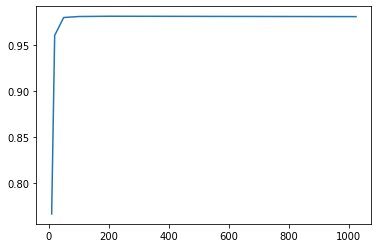

In [ ]:
plt.plot(D,model_svd_accuracies)

# Question 2

In [ ]:
D = 20
output1 = 10
units = 1024

class Q2Net(nn.Module):
    
    def __init__(self,input1,input2):

        super(Q2Net,self).__init__()

        model_Q1 = BaseNet(input1 = input1, input2 = input2).to(dev)
        model_Q1.load_state_dict(torch.load('/content/network-mnist.pt'))

        self.v_input = nn.Linear(input1*input2, 20, bias = False)
        self.u_input = nn.Linear(D, units, bias = True)

        u_in, s_in, v_in = torch.svd(model_Q1.input.weight.data)

        self.u_input.weight.data = u_in[:,0:20]
        self.v_input.weight.data = torch.mm(torch.diag(s_in)[0:20, 0:20], v_in[:, 0:20].t())


        self.v_hide1 = nn.Linear(units, 20, bias = False)
        self.u_hide1 = nn.Linear(D, units, bias = True)

        u_h1, s_h1, v_h1 = torch.svd(model_Q1.hide1.weight.data)

        self.u_hide1.weight.data = u_h1[:,0:20]
        self.v_hide1.weight.data = torch.mm(torch.diag(s_h1)[0:20, 0:20], v_h1[:, 0:20].t())

        self.v_hide2 = nn.Linear(units, 20, bias = False)
        self.u_hide2 = nn.Linear(20, units, bias = True)

        u_h2, s_h2, v_h2 = torch.svd(model_Q1.hide2.weight.data)

        self.u_hide2.weight.data = u_h2[:,0:20]
        self.v_hide2.weight.data = torch.mm(torch.diag(s_h2)[0:20, 0:20], v_h2[:,0:20].t())

        self.v_hide3 = nn.Linear(units, 20, bias = False)
        self.u_hide3 = nn.Linear(20, units, bias = True)

        u_h3, s_h3, v_h3 = torch.svd(model_Q1.hide3.weight.data)

        self.u_hide3.weight.data = u_h3[:,0:20]
        self.v_hide3.weight.data = torch.mm(torch.diag(s_h3)[0:20, 0:20], v_h3[:, 0:20].t())

        self.v_hide4 = nn.Linear(units, 20, bias = False)
        self.u_hide4 = nn.Linear(20, units, bias = True)

        u_h4, s_h4, v_h4 = torch.svd(model_Q1.hide4.weight.data)

        self.u_hide4.weight.data = u_h4[:,0:20]
        self.v_hide4.weight.data = torch.mm(torch.diag(s_h4)[0:20, 0:20], v_h4[:, 0:20].t())

        self.output = nn.Linear(units, output1)

              
    def forward(self, network):

        network = self.v_input(network)
        network = self.u_input(network)
        network = F.relu(network)

        network = self.v_hide1(network)
        network = self.u_hide1(network)
        network = F.relu(network)

        network = self.v_hide2(network)
        network = self.u_hide2(network)
        network = F.relu(network)

        network = self.v_hide3(network)
        network = self.u_hide3(network)
        network = F.relu(network)

        network = self.v_hide4(network)
        network = self.u_hide4(network)

        network = F.relu(network)

        network = self.output(network) 

        return network

In [ ]:
from sklearn.metrics import accuracy_score

input1 = 28
input2 = 28
batch_size = 512
epochs = 200
activation = nn.CrossEntropyLoss()
lr = 0.0001
q2_model = Q2Net(input1 = input1, input2 = input2).to(dev)
#q2_model.apply(weight_data)
valid_loss, accuracy_final = train_neural_network_Q1(model = q2_model, train_dataset = mnist_train, test_dataset = mnist_test, epochs = epochs, batch_size = batch_size, lr = lr, activation = activation, assess = accuracy_score, input1 = input1, input2 = input2, dev = dev)

Current_epoch:1
Accuracy: 0.9721
Current_epoch:2
Accuracy: 0.9772
Current_epoch:3
Accuracy: 0.9789
Current_epoch:4
Accuracy: 0.9797
Current_epoch:5
Accuracy: 0.9788
Current_epoch:6
Accuracy: 0.9799
Current_epoch:7
Accuracy: 0.9809


# Question 3

In [ ]:
class autograd(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        
        u,s,v = torch.svd(input)
        w_cap = torch.mm(torch.mm(u[:,0:20], torch.diag(s)[0:20, 0:20]), v[:, 0:20].t())
        ctx.save_for_backward(input, w_cap)
        return w_cap

    @staticmethod    
    def backward(ctx, grad_output):
        input,output = ctx.saved_tensors
        return grad_output*1

In [ ]:
class Q3Net(nn.Module):

  def __init__(self, input1, input2):

        super(Q3Net,self).__init__()
        self.inp = nn.Linear(input1*input2, units)
        #self.input.weight = torch.nn.Parameter()

        self.hide1 = nn.Linear(units, units)
        #self.hide1.weight = torch.nn.Parameter()

        self.hide2 = nn.Linear(units, units)
        #self.hide2.weight = torch.nn.Parameter()

        self.hide3 = nn.Linear(units, units)
        #self.hide3.weight = torch.nn.Parameter()

        self.hide4 = nn.Linear(units, units)
        #self.hide4.weight = torch.nn.Parameter()

        self.output = nn.Linear(units, output1)
        self.autograd = autograd.apply

  def forward(self, network):

        input_svd = self.autograd(self.inp.weight)
        self.inp.weight = torch.nn.Parameter(input_svd)
        network = self.inp(network)
        network = F.relu(network)

        hide1_svd = self.autograd(self.hide1.weight)
        self.hide1.weight = torch.nn.Parameter(hide1_svd)
        network = self.hide1(network)
        network = F.relu(network)

        hide2_svd = self.autograd(self.hide2.weight)
        self.hide2.weight = torch.nn.Parameter(hide2_svd)
        network = self.hide2(network)
        network = F.relu(network)

        hide3_svd = self.autograd(self.hide3.weight)
        self.hide3.weight = torch.nn.Parameter(hide3_svd)
        network = self.hide3(network)
        network = F.relu(network)

        hide4_svd = self.autograd(self.hide4.weight)
        self.hide4.weight = torch.nn.Parameter(hide4_svd)
        network = self.hide4(network)
        network = F.relu(network)

        network = self.output(network) 
        return network


In [ ]:
from sklearn.metrics import accuracy_score

input1 = 28
input2 = 28
batch_size = 512
epochs = 12
activation = nn.CrossEntropyLoss()
lr = 0.001
q3_model = Q3Net(input1 = input1, input2 = input2).to(dev)
model_svd = BaseNet(input1 = input1, input2 = input2).to(dev)
model_svd.load_state_dict(torch.load("/content/network-mnist.pt"), strict = False)

q3_model.inp.weight =  torch.nn.Parameter(model_svd.input.weight.data)
q3_model.hide1.weight = torch.nn.Parameter(model_svd.hide1.weight.data)
q3_model.hide2.weight = torch.nn.Parameter(model_svd.hide2.weight.data)
q3_model.hide3.weight = torch.nn.Parameter(model_svd.hide3.weight.data)
q3_model.hide4.weight = torch.nn.Parameter(model_svd.hide4.weight.data)

valid_loss_q3, accuracy_final_q3 = train_neural_network_Q1(model = q3_model, train_dataset = mnist_train, test_dataset = mnist_test, epochs = epochs, batch_size = batch_size, lr = lr, activation = activation, assess = accuracy_score, input1 = input1, input2 = input2, dev = dev)

Current_epoch:1
Accuracy: 0.9633
Current_epoch:2
Accuracy: 0.9646
Current_epoch:3
Accuracy: 0.9672
Current_epoch:4
Accuracy: 0.968
Current_epoch:5
Accuracy: 0.9681
Current_epoch:6
Accuracy: 0.9692
Current_epoch:7
Accuracy: 0.9693
Current_epoch:8
Accuracy: 0.9697
Current_epoch:9
Accuracy: 0.9702
Current_epoch:10
Accuracy: 0.9715
Current_epoch:11
Accuracy: 0.9715
Current_epoch:12
Accuracy: 0.9712


# Question 4

In [2]:
file_train = pickle.load(open("/content/hw4_trs.pkl", "rb"))

train_labels = np.zeros((500,1))
count = 0
train_speakers = 50
train_utter = 10

for i in range(0, train_speakers):
  for j in range(0,train_utter):
    train_labels[count] = i
    count = count + 1

print(len(train_labels))

# print(train_labels)

500


In [3]:
file_test = pickle.load(open("/content/hw4_tes.pkl", "rb"))

test_labels = np.zeros((200,1))
count = 0
test_speakers = 20
test_utter = 10

for i in range(0, test_speakers):
  for j in range(0, test_utter):
    test_labels[count] = i
    count = count + 1

print(len(test_labels))
# print(test_labels)

200


In [4]:
def lib_stft_train(file_1):
    X_train = librosa.stft(file_1, n_fft=1024, hop_length=512)
    X_abs = np.abs(X_train)
    x_trans = np.transpose(X_abs)
    return(x_trans)

In [5]:
pairs = []
print(file_train.shape)
# for i in range(0,500):
#   X_train = librosa.stft(file_train[i, :], n_fft=1024, hop_length=512)
# X_abs = np.abs(X_train)
# x_trans = np.transpose(X_abs)
x_trans = np.apply_along_axis(lib_stft_train,1,file_train)
train_labels = np.array(train_labels)
tr_lab_len = len(train_labels)
train_sub = np.arange(0, tr_lab_len).reshape(-1,1)

pair_labels = np.zeros((90,1))
pair_labels[0:45] = 1

#print(train_labels)
#print(train_sub)

uniq_tr_labels = np.unique(train_labels)
#print(uniq_tr_labels)

for i in range(0, len(uniq_tr_labels)):
  value = uniq_tr_labels[i]
  #print(value)
  train_speaker_sim = np.where(train_labels == value)
  train_speaker_noeq = np.where(train_labels!=value)

  train_pos = train_sub[train_speaker_sim]
  train_neg = train_sub[train_speaker_noeq]

  #print(train_pos)
  #print(train_neg)

  pos_comb = list(combinations(train_pos,2))
  #print(pos_comb)

  pos_rand_comb = random.sample(pos_comb, 45)
  #print(len(pos_rand_comb))
  final_pos = np.array(pos_rand_comb)
  #print(final_pos)


  neg_comb = list(product(train_pos,train_neg))
  #print(neg_comb)

  neg_rand_comb = random.sample(neg_comb, 45)
  #print(neg_rand_comb)

  final_neg = np.array(neg_rand_comb)

  final_neg_pos = np.concatenate((final_pos, final_neg), 0)
  #print(len(final_neg_pos))

  a1 = final_neg_pos[:,0].reshape(-1,1)
  a2 = final_neg_pos[:,1].reshape(-1,1)
  print(a1.shape)
  print(a2.shape)
  print(x_trans.shape)

  x_lam = lambda j:x_trans[j]
  #print(x_lam)
  # for i in range(0,90):
  #   pair_1 = x_lam((a1[i,:]))
  #   pair_2 = x_lam(a2[i,:])

  pair_1 = np.apply_along_axis(x_lam,1, a1)
  pair_2 = np.apply_along_axis(x_lam,1, a2)
  
  print(pair_1.shape)
  print(pair_2.shape)

  pairs.append((pair_1, pair_2, pair_labels))

dataset_train = DataLoader(pairs)

(500, 16180)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90, 1)
(500, 32, 513)
(90, 1, 32, 513)
(90, 1, 32, 513)
(90, 1)
(90,

In [6]:
def lib_stft_test(file_1):
    X_test = librosa.stft(file_1, n_fft=1024, hop_length=512)
    X_abs = np.abs(X_test)
    x_trans = np.transpose(X_abs)
    return(x_trans)

In [147]:
pairs = []
print(file_test.shape)
x_trans = np.apply_along_axis(lib_stft_test,1,file_test)
test_labels = np.array(test_labels)
test_lab_len = len(test_labels)
test_sub = np.arange(0, test_lab_len).reshape(-1,1)

pair_labels = np.zeros((90,1))
pair_labels[0:45] = 1

uniq_test_labels = np.unique(test_labels)

for i in range(0, len(uniq_test_labels)):
  value = uniq_test_labels[i]
  test_speaker_sim = np.where(test_labels == value)
  test_speaker_noeq = np.where(test_labels!=value)

  test_pos = test_sub[test_speaker_sim]
  test_neg = test_sub[test_speaker_noeq]

  pos_comb = list(combinations(test_pos,2))

  pos_rand_comb = random.sample(pos_comb, 45)
  final_pos = np.array(pos_rand_comb)

  neg_comb = list(product(test_pos,test_neg))

  neg_rand_comb = random.sample(neg_comb, 45)

  final_neg = np.array(neg_rand_comb)

  final_neg_pos = np.concatenate((final_pos, final_neg), 0)

  a1 = final_neg_pos[:,0].reshape(-1,1)
  a2 = final_neg_pos[:,1].reshape(-1,1)
  print(a1.shape)
  print(a2.shape)
  print(x_trans.shape)

  x_lam = lambda j:x_trans[j]
  # for i in range(0,90):
  #   pair_1 = x_lam((a1[i,:]))
  #   pair_2 = x_lam(a2[i,:])

  pair_1 = np.apply_along_axis(x_lam,1, a1)
  pair_2 = np.apply_along_axis(x_lam,1, a2)

  print(pair_1.shape)
  print(pair_2.shape)

  pairs.append((pair_1, pair_2, pair_labels))

dataset_test = DataLoader(pairs)

(200, 22631)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90, 1)
(200, 45, 513)
(90, 1, 45, 513)
(90, 1, 45, 513)
(90, 1)
(90,

In [254]:
class Q4Net(nn.Module):
  
  def __init__(self):

        super(Q4Net,self).__init__()
        
        self.layer1 = nn.LSTM(input_size=513, hidden_size=16, num_layers=1, batch_first=True, bidirectional=True)   
        self.layer2 = nn.Linear(32,64)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.prelu = nn.PReLU(init=1.5)
        self.sigmoid = nn.Sigmoid()

  def forward(self, network, out):
        
        lstm_1 = pack_padded_sequence(network, out, batch_first=True)
        lstm_1, (x, y) = self.layer1(lstm_1)
        x = x.reshape(x.shape[1],-1)
        network = self.prelu(x)
        network = self.dropout(network)
        network = self.relu(network)
        network = self.layer2(network)
        network = self.dropout(network)
        network = self.sigmoid(network)

        return network

In [255]:
class siamese_net():
  def __init__(self, model, dataset_train, dataset_test):
    
    img1,img2,labels = next(iter(dataset_train))
    self.model = model().to(dev)
    self.dataset_train = dataset_train
    self.dataset_test = dataset_test
    self.valid = np.sum(np.array([img1.shape[1] for img1,img2,labels in dataset_test])).astype(np.float)

  
  def train_neural_network_Q4(self,epochs,lr,assess,activation,verbose=True,dev=dev):    

    self.valid_loss_final = []
    self.train_loss_final = []
    self.accuracy_final = []
    initial = 1
    stop = False
    top = 0.59

    optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    while ((initial <= epochs) and (stop==False)):

      train_loss = 0

      for img1,img2,labels in self.dataset_train:

        img1 = img1.squeeze().to(dev)
        img1_full = torch.full((img1.shape[0],1),img1.shape[1])
        len_img1 = img1_full.reshape(-1)
        img2 = img2.squeeze().to(dev)
        img2_full = torch.full((img2.shape[0],1),img2.shape[1])
        len_img2 = img2_full.reshape(-1)
        labels = labels.squeeze().float().to(dev)
        
        out_1 = self.model.forward(img1,len_img1)
        out_2 = self.model.forward(img2,len_img2)
        out1_view = out_1.view(out_1.shape[0], 1, out_1.shape[1])
        out2_view = out_2.view(out_2.shape[0], out_2.shape[1], 1)
        bmm_test = torch.bmm(out1_view.to(dev), out2_view.to(dev))
        out_final =  bmm_test.reshape(-1,1).to(dev)       
        loss = activation(out_final,labels.reshape(-1,1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

      self.train_loss_final.append(train_loss/len(self.dataset_train))

      with torch.no_grad():
        test_loss = 0
        validation_loss = 0.0

        for img1,img2,labels in self.dataset_test:
          img1 = img1.squeeze().to(dev)
          img1_full = torch.full((img1.shape[0],1),img1.shape[1])
          len_img1 = img1_full.reshape(-1)
          img2 = img2.squeeze().to(dev)
          img2_full = torch.full((img2.shape[0],1),img2.shape[1])
          len_img2 = img2_full.reshape(-1)
          labels = labels.squeeze().float().to(dev)
  
          out_1 = self.model.forward(img1,len_img1)
          out_2 = self.model.forward(img2,len_img2)
          out1_view = out_1.view(out_1.shape[0], 1, out_1.shape[1])
          out2_view = out_2.view(out_2.shape[0], out_2.shape[1], 1)
          bmm_test = torch.bmm(out1_view.to(dev), out2_view.to(dev))
          out_final =  bmm_test.reshape(-1,1).to(dev)
          out_sig = torch.sigmoid(out_final)
          loss = activation(out_final,labels.reshape(-1,1))
          test_loss += loss.item()
          out_gt = torch.gt(out_sig, 0.7).int()
          accuracy = assess(labels.reshape(-1,1).cpu().numpy(), out_gt.argmax(1).cpu().numpy())

          self.accuracy_final.append(accuracy)

          validation_loss += torch.sum(torch.eq(out_gt.reshape(-1),labels.reshape(-1))).item()

        accuracy_validation = float(validation_loss)/self.valid
        self.valid_loss_final.append(test_loss/len(self.dataset_test))

        print("Current_epoch:"+str(initial))
        print("Accuracy: "+str(accuracy_validation))

        initial += 1

    return self.train_loss_final, self.valid_loss_final

In [256]:
siamese_n = siamese_net(Q4Net, dataset_train, dataset_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [257]:
from sklearn.metrics import accuracy_score

activation = nn.BCEWithLogitsLoss()
train_loss_siam, valid_loss_siam = siamese_n.train_neural_network_Q4(epochs=20,lr=0.0001,assess = accuracy_score,dev = dev, activation = activation)

Current_epoch:1
Accuracy: 0.5
Current_epoch:2
Accuracy: 0.5
Current_epoch:3
Accuracy: 0.5
Current_epoch:4
Accuracy: 0.5
Current_epoch:5
Accuracy: 0.5
Current_epoch:6
Accuracy: 0.5
Current_epoch:7
Accuracy: 0.5
Current_epoch:8
Accuracy: 0.5
Current_epoch:9
Accuracy: 0.5
Current_epoch:10
Accuracy: 0.5
Current_epoch:11
Accuracy: 0.5
Current_epoch:12
Accuracy: 0.5
Current_epoch:13
Accuracy: 0.5
Current_epoch:14
Accuracy: 0.5094444444444445
Current_epoch:15
Accuracy: 0.5183333333333333
Current_epoch:16
Accuracy: 0.5555555555555556
Current_epoch:17
Accuracy: 0.595
Current_epoch:18
Accuracy: 0.6188888888888889
Current_epoch:19
Accuracy: 0.685
Current_epoch:20
Accuracy: 0.6961111111111111
